# Multi-step forecasting: linear regression

In the previous notebook, we forecasted hourly pollutant concentrations over the next 24 hours, utilizing a simple or naive forecast, where the future concentration was given by the concentration in the previous hour.

In this notebook, we will add a small layer of complexity: we will predict the next hour pollutant concentration as a linear function of the concentration in the previous hour.

**For simplicity, we will only forecast the concentration of Carbon Monoxide (CO).**


## Data

We will work with the Air Quality Dataset from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Air+Quality).

For instructions on how to download, prepare, and store the dataset, refer to notebook number 3, in the folder "01-Datasets" from this repo.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# For missing data imputation.
from feature_engine.timeseries.forecasting import LagFeatures

# For the linear regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Load data

In [2]:
# We pack all data preparation steps from the
# previous notebook in a function.

def load_data():

    # Data lives here.
    filename = "../datasets/AirQualityUCI_ready.csv"

    # Load data: only the time variable and CO.
    data = pd.read_csv(
        filename,
        usecols=["Date_Time", "CO_sensor"],
        parse_dates=["Date_Time"],
        index_col=["Date_Time"],
    )

    # Sanity: sort index.
    data.sort_index(inplace=True)

    # Reduce data span.
    data = data["2004-04-01":"2005-04-30"]

    # Remove outliers
    data = data.loc[(data["CO_sensor"] > 0)]

    return data

In [3]:
# Load data with our new function.

data = load_data()

data.head()

,CO_sensor
Date_Time,
2004-04-04 00:00:00,1224.0
2004-04-04 01:00:00,1215.0
2004-04-04 02:00:00,1115.0
2004-04-04 03:00:00,1124.0
2004-04-04 04:00:00,1028.0


# Split data into train and test

We train the model on a training set and evaluate its performance on a test set. It is good practice to evaluate models on datasets that were not used for training.

In this case, differently from the previous notebook, our model does learn parameters from the data. So we want to be sure we train the model only with the training set.

In [4]:
# Split the data.

# input data
X_train = data[data.index < "2005-03-04"]["CO_sensor"].to_frame()
X_test = data[data.index >= "2005-03-04"]["CO_sensor"].to_frame()

# target
y_train = data[data.index < "2005-03-04"]["CO_sensor"]
y_test = data[data.index >= "2005-03-04"]["CO_sensor"]

# Lag feature

To predict the target as a linear function of its concentration in the previous hour, we need to create **a new feature** that will be the input variable to our linear model. This feature is the pollutant concentration in the previous hour.

In section 2, we created this feature using Pandas. Here, we will use Feature-engine.

In [5]:
# Add the lag 1 Hr feature.

lag1 = LagFeatures(
    freq="1H",  # move 1 hr forward
    drop_original=True,  # drop input variable
    missing_values="ignore",
)

X_train_t = lag1.fit_transform(X_train)

X_train_t.head()

,CO_sensor_lag_1H
Date_Time,
2004-04-04 00:00:00,NaN
2004-04-04 01:00:00,1224.0
2004-04-04 02:00:00,1215.0
2004-04-04 03:00:00,1115.0
2004-04-04 04:00:00,1124.0


We now have a dataframe with the input feature for our model, the lag feature of the pollutant concentration.

In [6]:
# Check if we introduced missing data.

X_train_t.isnull().sum()

CO_sensor_lag_1H    25
dtype: int64

Lagging features introduces missing values. We will remove these values from the data, using a transformer from Feature-engine.

# Drop missing data

In [7]:
# We drop missing data.
X_train_t.dropna(inplace=True)

# Check na
X_train_t.isnull().sum()

CO_sensor_lag_1H    0
dtype: int64

We now need to remove the observations from the target that are no longer present in the train set.

In [8]:
print(y_train.shape)

y_train_t = y_train.loc[X_train_t.index]

print(y_train_t.shape)

(6850,)
(6825,)


# Linear regression

Let's train a Lasso regression to forecast pollutant concentration in the next hour.

In [9]:
lin_reg = LinearRegression()

lin_reg.fit(X_train_t, y_train_t)

LinearRegression()

In [10]:
# Make predictions

preds = lin_reg.predict(X_train_t)

preds

array([1206.62362723, 1198.69075923, 1110.54778153, ..., 1358.22954888,
       1260.39084363, 1190.75789124])

Text(0.5, 1.0, 'Forecast')

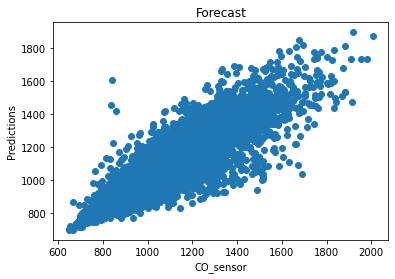

In [11]:
# Plot the predictions vs the truth.

plt.scatter(y_train_t, preds)
plt.xlabel("CO_sensor")
plt.ylabel("Predictions")
plt.title("Forecast")

We see that our linear regression makes fairly good predictions of the pollutant concentration in the next hour.

# Multi-step forecasting

To carry out multi-step forecasting, first we make the prediction for the following hour, and then we use that prediction value as a new feature to predict the concentration for the following hour, and so on.

## Forecasting 1 hour forward

In our training set, we've got data up to March 3rd at 23 hr. Let's use that data to forecast the pollutant concentration for March 4th at 00 hr.

In [12]:
# The last value in the train set.

mini_df = X_train.tail(1)

mini_df

,CO_sensor
Date_Time,
2005-03-03 23:00:00,1179.0


In [13]:
# Create a step forward.

step = pd.DataFrame(
    data="NA",
    index=[X_train.iloc[-1].name + pd.offsets.Hour(1)],
    columns=["CO_sensor"],
)

step

,CO_sensor
2005-03-04,NA


In [14]:
# Add the step forward to the mini_df.

mini_df = mini_df.append(
    step,
    ignore_index=False,
    verify_integrity=True,
    sort=True,
)

mini_df

,CO_sensor
2005-03-03 23:00:00,1179.0
2005-03-04 00:00:00,NA


In [15]:
# Create the new input feaure.

mini_df_t = lag1.transform(mini_df)

mini_df_t

,CO_sensor_lag_1H
2005-03-03 23:00:00,NaN
2005-03-04 00:00:00,1179.0


In [16]:
# Drop missing data

mini_df_t.dropna(inplace=True)

mini_df_t

,CO_sensor_lag_1H
2005-03-04,1179.0


In [17]:
# Forecast the pollutant concentration in the next
# hour.

pred = lin_reg.predict(mini_df_t)

pred

array([1166.95928726])

## Forecasting 2 hours forward

In [18]:
mini_df

,CO_sensor
2005-03-03 23:00:00,1179.0
2005-03-04 00:00:00,NA


In [19]:
# Add the prediction

mini_df.iloc[-1] = pred[0]

mini_df

,CO_sensor
2005-03-03 23:00:00,1179.000000
2005-03-04 00:00:00,1166.959287


In [20]:
# Append the next step

step = pd.DataFrame(
    data="NA",
    index=[mini_df.iloc[-1].name + pd.offsets.Hour(1)],
    columns=["CO_sensor"],
)

mini_df = mini_df.append(
    step,
    ignore_index=False,
    verify_integrity=True,
    sort=True,
)

mini_df

,CO_sensor
2005-03-03 23:00:00,1179.000000
2005-03-04 00:00:00,1166.959287
2005-03-04 01:00:00,NA


In [21]:
# Create lag feature
mini_df_t = lag1.transform(mini_df.tail(2))

# Remove missing data
mini_df_t.dropna(inplace=True)

# Obtain prediction
pred = lin_reg.predict(mini_df_t)

pred

array([1156.34624451])

## Forecasting 3 hours forward

In [22]:
mini_df

,CO_sensor
2005-03-03 23:00:00,1179.000000
2005-03-04 00:00:00,1166.959287
2005-03-04 01:00:00,NA


In [23]:
# Add the prediction.

mini_df.iloc[-1] = pred[0]

mini_df

,CO_sensor
2005-03-03 23:00:00,1179.000000
2005-03-04 00:00:00,1166.959287
2005-03-04 01:00:00,1156.346245


In [24]:
# Append the next step.

step = pd.DataFrame(
    data="NA",
    index=[mini_df.iloc[-1].name + pd.offsets.Hour(1)],
    columns=["CO_sensor"],
)

mini_df = mini_df.append(
    step,
    ignore_index=False,
    verify_integrity=True,
    sort=True,
)

mini_df

,CO_sensor
2005-03-03 23:00:00,1179.000000
2005-03-04 00:00:00,1166.959287
2005-03-04 01:00:00,1156.346245
2005-03-04 02:00:00,NA


In [25]:
# Create lag feature
mini_df_t = lag1.transform(mini_df.tail(2))

# Remove missing data
mini_df_t.dropna(inplace=True)

# Obtain prediction
pred = lin_reg.predict(mini_df_t)

pred

array([1146.99159261])

And we continue on an on. You get the gist.

## Forecasting 24 hours forward

Let's now streamline this procedure to forecast the next 24 hours of pollutant concentration.

Much of this code is the same that we described previously. We just put it in a loop.

In [26]:
# The last value in the train set.

mini_df = X_train.tail(1)

mini_df

,CO_sensor
Date_Time,
2005-03-03 23:00:00,1179.0


In [27]:
# Add a step forward.

step = pd.DataFrame(
    data="NA",
    index=[X_train.iloc[-1].name + pd.offsets.Hour(1)],
    columns=["CO_sensor"],
)

mini_df = mini_df.append(
    step,
    ignore_index=False,
    verify_integrity=True,
    sort=True,
)

mini_df

,CO_sensor
2005-03-03 23:00:00,1179.0
2005-03-04 00:00:00,NA


In [28]:
# Predict pollutant in the next hour
mini_df_t = lag1.transform(mini_df)

mini_df_t.dropna(inplace=True)

pred = lin_reg.predict(mini_df_t)

pred

array([1166.95928726])

In [29]:
# Now we use the prediction as input to make
# the prediction in the following hour.

# And we repeat the process 23 times:

for i in range(23):

    # Add the prediction to the df
    mini_df.iloc[-1] = pred[0]

    # Add a step forward
    step = pd.DataFrame(
        data="NA",
        index=[mini_df.iloc[-1].name + pd.offsets.Hour(1)],
        columns=["CO_sensor"],
    )

    mini_df = mini_df.append(
        step,
        ignore_index=False,
        verify_integrity=True,
        sort=True,
    )

    # Create the feature
    mini_df_t = lag1.transform(mini_df.tail(2))

    # Drop NA
    mini_df_t.dropna(inplace=True)

    # Make the prediction
    pred = lin_reg.predict(mini_df_t)

# Ad final prediction
mini_df.iloc[-1] = pred[0]

# Our 24 hr forecast.
mini_df = mini_df.drop(index=X_train.iloc[-1].name)

mini_df

,CO_sensor
2005-03-04 00:00:00,1166.959287
2005-03-04 01:00:00,1156.346245
2005-03-04 02:00:00,1146.991593
2005-03-04 03:00:00,1138.746124
2005-03-04 04:00:00,1131.478322
2005-03-04 05:00:00,1125.072265
2005-03-04 06:00:00,1119.425776
2005-03-04 07:00:00,1114.448792
2005-03-04 08:00:00,1110.061931
2005-03-04 09:00:00,1106.195220


In [30]:
# We can plot our predictions vs. the truth, which is
# the CO concentration in the test set.

tmp = mini_df.join(X_test, lsuffix="_left", rsuffix="_right")

tmp.columns = ["predicted", "actual"]

tmp

,predicted,actual
2005-03-04 00:00:00,1166.959287,929.0
2005-03-04 01:00:00,1156.346245,951.0
2005-03-04 02:00:00,1146.991593,938.0
2005-03-04 03:00:00,1138.746124,921.0
2005-03-04 04:00:00,1131.478322,850.0
2005-03-04 05:00:00,1125.072265,811.0
2005-03-04 06:00:00,1119.425776,848.0
2005-03-04 07:00:00,1114.448792,882.0
2005-03-04 08:00:00,1110.061931,936.0
2005-03-04 09:00:00,1106.195220,1022.0


Text(0, 0.5, 'CO concentration')

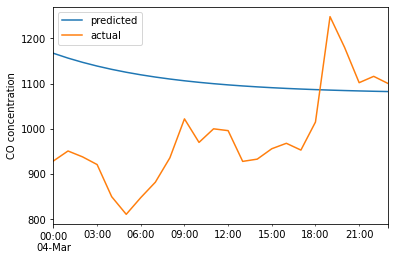

In [31]:
tmp.plot()
plt.ylabel("CO concentration")

Still not an amazing model.

In [32]:
# And now we calculate the RMSE for the 24 hr.
# predictions.

print(
    "rmse: ",
    mean_squared_error(
        tmp["predicted"],
        tmp["actual"],
        squared=False,
    ),
)

rmse:  172.90155101091543


# Back-testing with expanding window

Now, we will make predictions with an expanding window. We will train the model up to a certain point, and then make predictions 24 hours ahead. We will then train the model up to a point further in the future, and make predictions 24 hours ahead. And so on.



<img src='../images/backtesting.png' width="600" height="600">


In [33]:
# Capture first day on test set

start = X_test.iloc[0].name
start

Timestamp('2005-03-04 00:00:00')

In [34]:
# capture last day on test set

end = X_test.iloc[-1].name
end

Timestamp('2005-04-04 14:00:00')

In [35]:
# Create a 24 hr date range.

pd.date_range(start=start, end=end, freq="24H")

DatetimeIndex(['2005-03-04', '2005-03-05', '2005-03-06', '2005-03-07',
               '2005-03-08', '2005-03-09', '2005-03-10', '2005-03-11',
               '2005-03-12', '2005-03-13', '2005-03-14', '2005-03-15',
               '2005-03-16', '2005-03-17', '2005-03-18', '2005-03-19',
               '2005-03-20', '2005-03-21', '2005-03-22', '2005-03-23',
               '2005-03-24', '2005-03-25', '2005-03-26', '2005-03-27',
               '2005-03-28', '2005-03-29', '2005-03-30', '2005-03-31',
               '2005-04-01', '2005-04-02', '2005-04-03', '2005-04-04'],
              dtype='datetime64[ns]', freq='24H')

Our expanding windows correspond to adding 1 additional day of data to the train set.

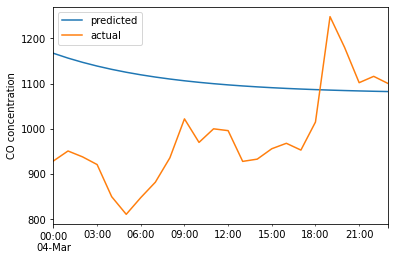

rmse:  172.90155101091543


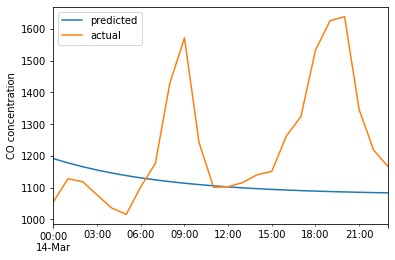

rmse:  237.82538468898213


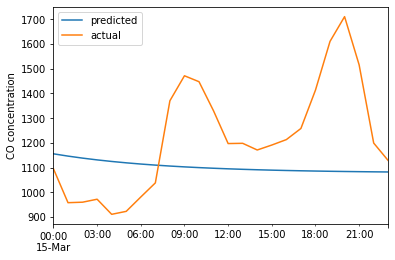

rmse:  261.57171136461136


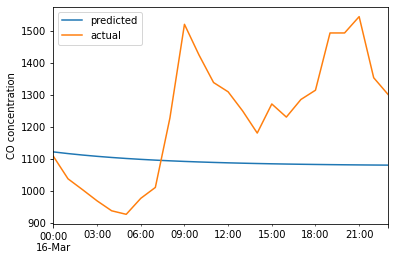

rmse:  242.15781785595033


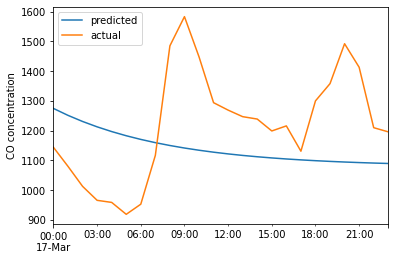

rmse:  226.72389770530685


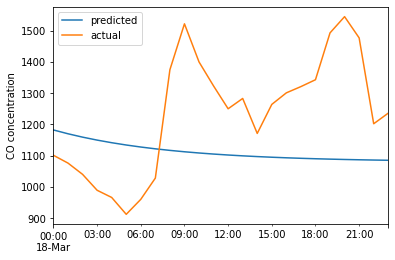

rmse:  237.2186936596755


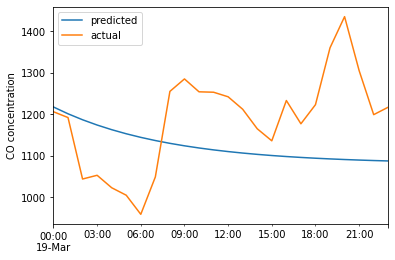

rmse:  149.73677202194418


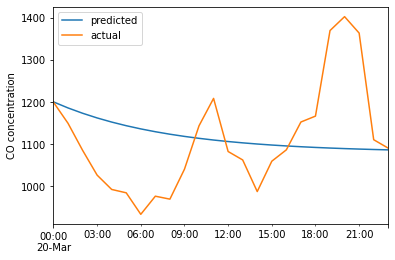

rmse:  138.5537554343391


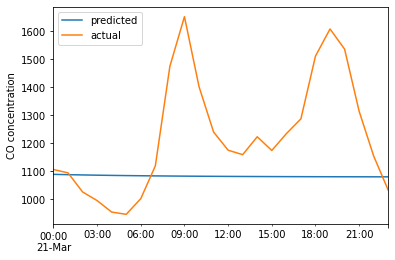

rmse:  250.5542523320272


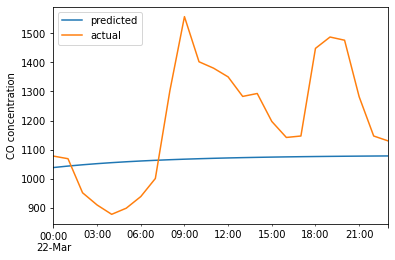

rmse:  234.38400357320398


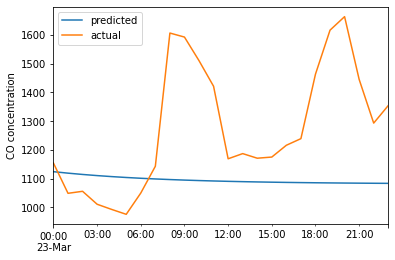

rmse:  282.63143960972343


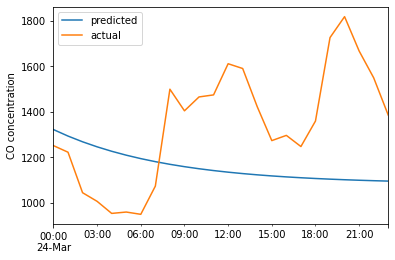

rmse:  346.95079386987476


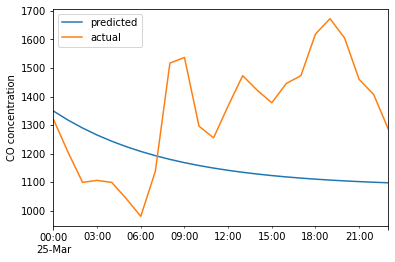

rmse:  296.2215260014245


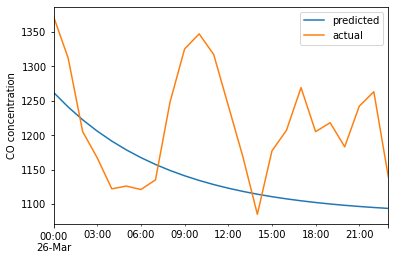

rmse:  111.10442640032394


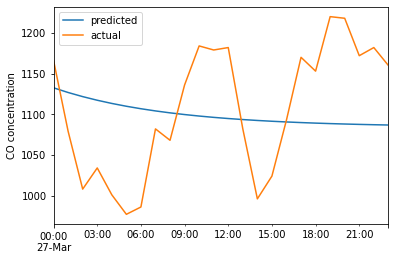

rmse:  84.93132936968317


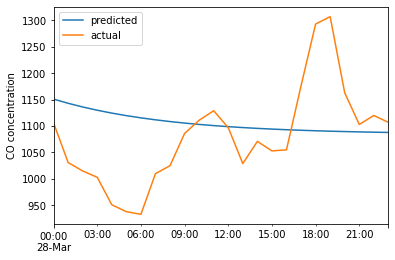

rmse:  106.16652373870767


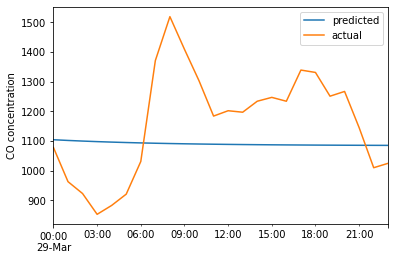

rmse:  193.32398577259434


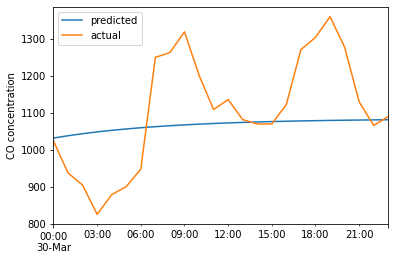

rmse:  146.70637337823672


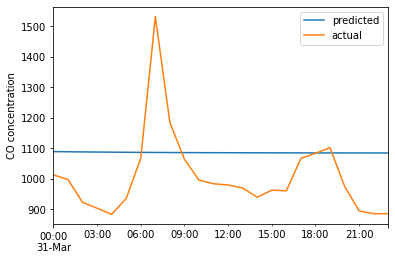

rmse:  154.00132119446445


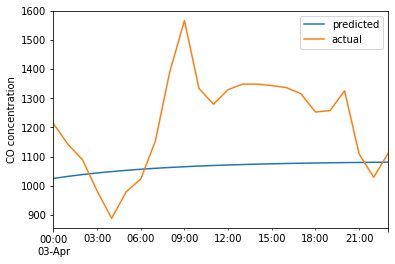

rmse:  215.55760832385633


In [36]:
# We collect the RMSE for each
# test set portion examined.
rmse_ls = []

# Now we loop, expanding the train set 24 hr.
# on each round.

for date in pd.date_range(start=start, end=end, freq="24H"):

    # Split the data:
    # Here we perform the expanding window.
    X_train = data[data.index < date]["CO_sensor"].to_frame()
    X_test = data[data.index >= date]["CO_sensor"].to_frame()

    y_train = data[data.index < date]["CO_sensor"]

    # Fit feature engineering steps
    X_train_t = lag1.fit_transform(X_train)

    # Drop missing data
    X_train_t.dropna(inplace=True)

    # Adjust y
    y_train_t = y_train.loc[X_train_t.index]

    # Fit regression model
    lin_reg.fit(X_train_t, y_train_t)

    # Forecast 1 hour forward:
    # ==========================

    # The last value in the train set
    mini_df = X_train.tail(1)

    # Add a step forward.
    step = pd.DataFrame(
        data="NA",
        index=[X_train.iloc[-1].name + pd.offsets.Hour(1)],
        columns=["CO_sensor"],
    )

    mini_df = mini_df.append(
        step,
        ignore_index=False,
        verify_integrity=True,
        sort=True,
    )

    # Predict pollutant in the next hour
    mini_df_t = lag1.transform(mini_df)

    mini_df_t.dropna(inplace=True)

    pred = lin_reg.predict(mini_df_t)

    # Multistep forecast:
    # ====================

    # And we repeat the process 23 times:
    for i in range(23):

        # Add the prediction to the df
        mini_df.iloc[-1] = pred[0]

        # Add a step forward
        step = pd.DataFrame(
            data="NA",
            index=[mini_df.iloc[-1].name + pd.offsets.Hour(1)],
            columns=["CO_sensor"],
        )

        mini_df = mini_df.append(
            step,
            ignore_index=False,
            verify_integrity=True,
            sort=True,
        )

        # Create the features
        mini_df_t = lag1.transform(mini_df.tail(2))
        mini_df_t.dropna(inplace=True)

        # Make the prediction
        pred = lin_reg.predict(mini_df_t)

    # Ad final prediction
    mini_df.iloc[-1] = pred[0]

    # Our 24 hr forecast.
    mini_df = mini_df.drop(index=X_train.iloc[-1].name)

    # ==================================================
    # Remember that we do not have timestamps for every
    # hour in our test set (discussed in Section 2).

    # We will plot only those cases where we do have
    # the real values of the target.
    # ==================================================

    # Join predictions and real values.
    tmp = mini_df.join(X_test, lsuffix="_left", rsuffix="_right")

    # Rename columns in dataframe.
    tmp.columns = ["predicted", "actual"]

    # Check that we have all real values of
    # the actual time series.
    if not tmp["actual"].isnull().any():

        tmp.plot()
        plt.ylabel("CO concentration")
        plt.show()

        # Determine the RMSE.
        rmse_ = mean_squared_error(
            y_true=tmp["actual"],
            y_pred=tmp["predicted"],
            squared=False,
        )
        print("rmse: ", rmse_)

        # Append the RMSE to our list.
        rmse_ls.append(rmse_)

We made 24 hr forecasts for multiple chunks of the test set.

To wrap-up, we determine the mean RMSE for every day in the test set that we examined.

In [37]:
# Mean performance during cross-validation

print("rmse: ", np.mean(rmse_ls), "+-", np.std(rmse_ls))
print("Number of days evaluated: ", len(rmse_ls))

rmse:  204.46115836529222 +- 67.95091634793904
Number of days evaluated:  20


The model does not seem to be much better than the naive forecast. Shame after so much work. But at least we could explore some of the challenges of multi-step forecasting.

In the next notebook, we will extract multiple features from the CO concentration to see if we can improve the forecasting model.